# TMP notebook
competition : RSNA Screening Mammography Breast Cancer Detection  
url : https://www.kaggle.com/competitions/rsna-breast-cancer-detection

# 2023/1/22
テーブルデータのみのlightgbmでどれくらい精度出るか検証  
* 交差検証なし、パラメータチューニングなし

## 結果
* LB - 0.04

In [ ]:
# import pandas as pd
# import lightgbm as lgb
# from sklearn.metrics import f1_score
# from sklearn.model_selection import train_test_split
# import warnings
# warnings.simplefilter('ignore')

# def pre_view(df):
#     if 'view' in df.columns.tolist():
#         df['view'] = df['view'].apply(lambda x: x if x=='CC' or x=='MLO' else 'others')
#     else:
#         pass
#     return df

# train = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')
# test = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/test.csv')
# submit = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/sample_submission.csv')

# column = ['laterality', 'view', 'age', 'implant', 'cancer']
# new_train = train[column]
# new_train = new_train.dropna()
# new_train = pre_view(new_train)
# new_train_dum = pd.get_dummies(new_train)
# train_cancer = new_train_dum[new_train_dum.cancer==1]
# train_no_cancer = new_train_dum[new_train_dum.cancer==0]
# tmp = train_no_cancer.sample(n=1158, random_state=0)
# concat_train = pd.concat([train_cancer, tmp])

# concat_train = concat_train.reset_index()
# X = concat_train.drop(columns=['cancer'])
# y = concat_train[['cancer']]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)
# # X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=0, stratify=y_test)

# model = lgb.LGBMClassifier(random_state=0)
# model.fit(X_train, y_train)
# pred = model.predict(X_test)
# print(f1_score(y_test, pred))

# tmp = test[['laterality', 'view', 'age', 'implant']]
# tmp = pre_view(tmp)
# tmp_ = pd.concat([new_train, tmp])
# tmp_dum = pd.get_dummies(tmp_)
# tmp_dum = tmp_dum.reset_index()
# test_X = tmp_dum.iloc[new_train.shape[0]:]
# test_X = test_X.drop(columns=['cancer'])
# test_pred = model.predict(test_X)
# print(test_pred)
# test_copy = test.copy()
# test_copy['pred'] = test_pred
# tmp = test_copy.groupby('prediction_id')['pred'].mean()
# sub = pd.DataFrame(data={'prediction_id': tmp.index.tolist(), 'cancer': tmp.values.tolist()})
# display(sub)
# sub.to_csv('submission.csv', index=None)

# 2023/1/28
画像について調べる

In [ ]:
# !pip install -qU python-gdcm pydicom pylibjpeg
# !pip install japanize-matplotlib
!pip install /kaggle/input/dicomsdl-offline-installer/dicomsdl-0.109.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl
import dicomsdl
import cv2
import os
import copy
import random
import pydicom
import numpy as np
import pandas as pd
import seaborn as sns
# import japanize_matplotlib
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 50)

from torch.utils.data import Dataset, DataLoader
#　使い方
# https://pystyle.info/pytorch-how-to-create-custom-dataset-class/
import torch

In [ ]:
train = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')
dicom_df = pd.read_csv('/kaggle/input/rsna-dicom-csv/dicom.csv')
custom_train = pd.read_csv('/kaggle/input/rsnacustomtrain/custom_train.csv')

In [ ]:
# sample_image = '/kaggle/input/rsna-breast-cancer-detection/train_images/10011/1031443799.dcm'
# im_data = pydicom.dcmread(sample_image)
# # print(im_data)
# data = im_data.pixel_array
# data.shape
# plt.imshow(im_data.pixel_array)
# plt.show()

In [ ]:
# fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(15, 10))
# axs = axs.flatten()
# for i in range(8):
#     if i <= 3:
#         MONO = 'MONOCHROME1'
#     else:
#         MONO = 'MONOCHROME2'
#     ran = random.randint(0,9000)
#     tmp = dicom_df[dicom_df.PhotometricInterpretation == MONO].iloc[ran]
#     p_id = tmp.patient_id
#     i_id = tmp.image_id
#     pas = f'/kaggle/input/rsna-breast-cancer-detection/train_images/{p_id}/{i_id}.dcm'
#     im_data = pydicom.dcmread(pas)
#     axs[i].imshow(im_data.pixel_array)
#     axs[i].axis('off')
# plt.show()

In [ ]:
def transform_image(paths, side='left', size=512, threshold=0.05):
    dicom_data = pydicom.dcmread(paths)
    data = np.array(dicom_data.pixel_array)
    data = data - np.min(data)
    data = data / np.max(data)
    if dicom_data.PhotometricInterpretation == "MONOCHROME1":
        data = 1.0 - data
    image = data[5:-5, 5:-5]

    ret, thresh = cv2.threshold(image, threshold, 1, 0)

    width = image.shape[1]
    # take all columns up to half image (in width), sumarize them and compare with other half
    if sum(sum(thresh[:, :width // 2])) > sum(sum(thresh[:, width // 2:])): 
        image_side = 'left'
    else:
        image_side = 'right'

    if image_side != side: 
        image = cv2.flip(image, 1)
    output= cv2.connectedComponentsWithStats((image > 0.05).astype(np.uint8)[:, :], 8, cv2.CV_32S)
    stats = output[2] # left, top, width, height, area_size

    idx = stats[1:, 4].argmax() + 1
    x1, y1, w, h = stats[idx][:4]
    x2 = x1 + w
    y2 = y1 + h

    image = image[y1: y2, x1: x2]
    image = cv2.resize(image, (size, size))
    return image

In [ ]:
# paths = [custom_train.filename[1]]
# data = transform_image(paths)
# plt.imshow(data[0])

In [ ]:
# path入力
# 余計な余白除去と左向き揃えをした画像が出力される
# リサイズ済み
class Image_preprocessor:
    def __init__(self,side='left', size=512):
        self.side = side
        self.size = size
        
    def preprocess(self, paths):
        images = []
        for image_path in paths:
            image = self.read_xray(image_path)
            image = self.crop_image(image)
            img_side = self.determine_side(image)
            if img_side != self.side: 
                image = cv2.flip(image, 1)
            image = self.img2roi(image)
            image = cv2.resize(image, (self.size, self.size))
            images.append(image)
        return images
    
    
    def read_xray(self, path, fix_monochrome = True):
        dicom = dicomsdl.open(path)
        data = dicom.pixelData(storedvalue=False)  # storedvalue = True for int16 return otherwise float32
        data = data - np.min(data)
        data = data / np.max(data)
        if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
            data = 1.0 - data
        return data

    def crop_image(self, image):
        # 画像によっては不要な枠があるので、取り除く
        image = image[5:-5, 5:-5]
        return image
    
    def img2roi(self, image):
        output= cv2.connectedComponentsWithStats((image > 0.05).astype(np.uint8)[:, :], 8, cv2.CV_32S)
        stats = output[2] # left, top, width, height, area_size

        idx = stats[1:, 4].argmax() + 1
        x1, y1, w, h = stats[idx][:4]
        x2 = x1 + w
        y2 = y1 + h

        image_fit = image[y1: y2, x1: x2]

        return image_fit
    
    def determine_side(self, img, threshold = 0.05):
        """
        img: input image
        threshold: for binirizing image, should be 5
        Side is determined simply by finding more white side of the image.
        """

        if img.dtype == 'float32':
            ret, thresh = cv2.threshold(img, threshold, 1, 0)
#         else:
#             img = (255*img).astype(dtype = 'float32')
#             ret, thresh = cv2.threshold(img, threshold, 1, 0)

        width = img.shape[1]
        # take all columns up to half image (in width), sumarize them and compare with other half
        if sum(sum(thresh[:, :width // 2])) > sum(sum(thresh[:, width // 2:])): 
            return 'left'
        else:
            return 'right'

In [ ]:
# paths = ['/kaggle/input/rsna-breast-cancer-detection/train_images/10006/1864590858.dcm', '/kaggle/input/rsna-breast-cancer-detection/train_images/10006/462822612.dcm']
# x = Image_preprocessor()
# data = x.preprocess(paths)
# plt.imshow(data[1])
# plt.show()
# print(data[0])

In [ ]:
# df = train.copy()
# root_dir = '/kaggle/input/rsna-breast-cancer-detection/train_images'
# df['filename'] = root_dir+'/'+df.patient_id.astype(str)+'/'+df.image_id.astype(str)+'.dcm'
# df['site_id_1'] = df['site_id_2'] = 0
# df['view_MLO'] = df['view_CC'] = df['view_AT'] = df['view_LM'] = df['view_ML'] = df['view_LMO'] = 0
# df['machine_49'] = df['machine_48'] = df['machine_29'] = df['machine_21'] = df['machine_93'] = df['machine_216'] = df['machine_210'] = df['machine_170'] = df['machine_190'] = df['machine_197'] = 0
# for i in range(df.shape[0]):
#     tmp = df.iloc[i]
#     s_value = tmp['site_id']
#     v_value = tmp['view']
#     m_value = tmp['machine_id']
#     s_name = f'site_id_{s_value}'
#     v_name = f'view_{v_value}'
#     m_name = f'machine_{m_value}'
#     df.loc[i, s_name] = 1
#     df.loc[i, v_name] = 1
#     df.loc[i, m_name] = 1
# train_input = df.drop(['site_id', 'patient_id', 'image_id', 'laterality', 'view', 'cancer', 'biopsy', 'filename', 'invasive', 'BIRADS', 'density', 'machine_id', 'difficult_negative_case'],axis=1)
# train_input['age'].fillna(60, inplace=True)
# train_input.isnull().sum()

In [ ]:
def pre_table(df, root_dir='/kaggle/input/rsna-breast-cancer-detection/train_images'):
    df['filename'] = root_dir+'/'+df.patient_id.astype(str)+'/'+df.image_id.astype(str)+'.dcm'
    df['site_id_1'] = df['site_id_2'] = 0
    df['view_MLO'] = df['view_CC'] = df['view_AT'] = df['view_LM'] = df['view_ML'] = df['view_LMO'] = 0
    df['machine_49'] = df['machine_48'] = df['machine_29'] = df['machine_21'] = df['machine_93'] = df['machine_216'] = df['machine_210'] = df['machine_170'] = df['machine_190'] = df['machine_197'] = 0
    for i in range(df.shape[0]):
        tmp = df.iloc[i]
        s_value = tmp['site_id']
        v_value = tmp['view']
        m_value = tmp['machine_id']
        s_name = f'site_id_{s_value}'
        v_name = f'view_{v_value}'
        m_name = f'machine_{m_value}'
        df.loc[i, s_name] = 1
        df.loc[i, v_name] = 1
        df.loc[i, m_name] = 1
    train_input = df.drop(['site_id', 'patient_id', 'image_id', 'laterality', 'view', 'cancer', 'biopsy', 'filename', 'invasive', 'BIRADS', 'density', 'machine_id', 'difficult_negative_case'], axis=1)
    train_input['age'].fillna(60, inplace=True)
    return train_input

# t = Image_preprocessor()
class RSNADataset(Dataset):
    def __init__(self, df, root_dir, is_preprocess=False, transform=False):
        self.table = df
        self.root_dir = root_dir
        self.is_preprocess = is_preprocess
        self.transform = transform
        
    def __len__(self):
        return self.table.shape[0]
    
    def __getitem__(self, idx):
        df_tmp = self.table
        if self.is_preprocess:
            train_dataset = pre_table(df_tmp, self.root_dir)
        else:
            train_dataset = self.table.drop(['site_id', 'patient_id', 'image_id', 'laterality', 'view', 'cancer', 'biopsy', 'filename', 'invasive', 'BIRADS', 'density', 'machine_id', 'difficult_negative_case'], axis=1)
        image_name = df_tmp.filename.tolist()[idx]
        image = t.preprocess(image_name)
        image = torch.Tensor(image)
        target = torch.Tensor(df_tmp['cancer'].tolist())[idx]
        sample = {'image': image,'answer':target}
        return sample
        
    

In [ ]:
# csv_file = '/kaggle/input/rsnacustomtrain/custom_train.csv'
# root_dir = '/kaggle/inpu/rsna-breast-cancer-detection/train_images'
# dataset = RSNADataset(custom_train, root_dir)

In [ ]:
from torchvision import datasets
import numpy as np
import pandas as pd
from torch import optim
import torch
CUDA_LAUNCH_BLOCKING=1
from torchvision import models
import torch.nn as nn
import os
from skimage import io, transform
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import skimage
from skimage.color import rgb2gray, gray2rgb
import cv2

In [ ]:
class TrainDataset(Dataset):
    def __init__(self, df):
        self.df = df
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        paths = self.df.filename.tolist()[idx]
        data = transform_image(paths)
        data = torch.Tensor(data)
        target = torch.Tensor(self.df['cancer'].tolist())[idx]
        sample = {'data': data, 'target': target}
        return sample
    

In [ ]:
# dataset = TrainDataset(custom_train)
# dataloader = DataLoader(dataset, batch_size=10)

In [ ]:
# for batch in dataloader:
#     print(batch['data'].shape)
#     print(batch['target'])

In [ ]:
import sys
sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
import timm
from pprint import pprint
pprint(timm.list_models(pretrained = True))

In [ ]:
# tmp_model = timm.create_model(model_name='resnest26d')

In [ ]:
import torch.nn as nn

class Effnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.effnet = timm.create_model(model_name = "tf_efficientnet_b0", pretrained = False)
        n_features = self.effnet.classifier.in_features
        self.effnet.classifier = nn.Linear(n_features, 1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.effnet(x)
        return x
model = Effnet()

In [ ]:
import torch
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(DEVICE)
print(DEVICE)

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())


In [ ]:
dataset = TrainDataset(custom_train)
dataloader = DataLoader(dataset, batch_size=10)

In [ ]:
# model.train()
# for data in dataloader:
#     optimizer.zero_grad()
#     X = data['data'].float().to(DEVICE)
#     y = data['target'].float().to(DEVICE)
#     pred = model(X)
#     loss = criterion(pred, y)
#     loss.backward()
#     optimizer.step()

# 2023/1/29

In [ ]:
!pip install -U pylibjpeg pylibjpeg-openjpeg pylibjpeg-libjpeg pydicom python-gdcm

In [ ]:
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import cv2
import pydicom
import gdcm
import pylibjpeg
import torch
import torch.nn as nn

In [ ]:
train = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')
dicom_df = pd.read_csv('/kaggle/input/rsna-dicom-csv/dicom.csv')
custom_train = pd.read_csv('/kaggle/input/rsnacustomtrain/custom_train.csv')

In [ ]:
def transform_image(paths, side='left', size=512, threshold=0.05):
    dicom_data = pydicom.dcmread(paths)
    data = np.array(dicom_data.pixel_array)
    data = data - np.min(data)
    data = data / np.max(data)
    if dicom_data.PhotometricInterpretation == "MONOCHROME1":
        data = 1.0 - data
    image = data[5:-5, 5:-5]

    ret, thresh = cv2.threshold(image, threshold, 1, 0)

    width = image.shape[1]
    # take all columns up to half image (in width), sumarize them and compare with other half
    if sum(sum(thresh[:, :width // 2])) > sum(sum(thresh[:, width // 2:])): 
        image_side = 'left'
    else:
        image_side = 'right'

    if image_side != side: 
        image = cv2.flip(image, 1)
    output= cv2.connectedComponentsWithStats((image > 0.05).astype(np.uint8)[:, :], 8, cv2.CV_32S)
    stats = output[2] # left, top, width, height, area_size

    idx = stats[1:, 4].argmax() + 1
    x1, y1, w, h = stats[idx][:4]
    x2 = x1 + w
    y2 = y1 + h

    image = image[y1: y2, x1: x2]
    image = cv2.resize(image, (size, size))
    return image

In [ ]:
class TrainDataset(Dataset):
    def __init__(self, df):
        super().__init__()
        self.df = df
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        f = self.df.filename.tolist()[index]
        image = transform_image(f)
        target = torch.Tensor(self.df.cancer.tolist())[index]
        image = torch.Tensor(image)
#         target = target.unsqueeze(dim=-1)
#         image = image.unsqueeze(dim=0)
        send = {'image': image, 'target': target}
        return send

In [ ]:
tmp_dataset = TrainDataset(custom_train)
tmp_dataloader = DataLoader(tmp_dataset, batch_size=30)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.pool = nn.MaxPool2d(2, stride=2)
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        
        self.fc1 = nn.Linear(32*253*253, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 10)
        self.fc4 = nn.Linear(10, 1)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = x.view(-1, 32*253*253)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return x
    

In [ ]:
import torch.optim as optim
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device("cuda:0")
net = Net()
net = net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.005)

In [ ]:
for epoch in range(3):
    print(f'epoch:{epoch}')
    for i, data in enumerate(tmp_dataloader):
        print(f'i:{i}')
        if i==20:
            break
        inputs = data['image']
        labels = data['target']
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.unsqueeze(dim=1)
        labels = labels.unsqueeze(dim=1)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        print(f'train_loss:{loss}')

#     for data in tmp_dataloader:
#         inputs = data['image']
#         inputs = inputs.unsqueeze(dim=1)
#         labels = data['target']
#         labels = labels.unsqueeze(dim=1)
#         inputs, labels = inputs.to(device), labels.to(device)
#         optimizer.zero_grad()
#         outputs = net(inputs)
#         loss = criterion(outputs, labels)
#         print(f'test_loss:{loss}')
        

## 2023/2/1

htmlをおしゃれにするやつを見つけたからやってみた

In [1]:
!wget http://bit.ly/3ZLyF82 -O CSS.css -q
    
from IPython.core.display import HTML
with open('./CSS.css', 'r') as file:
    custom_css = file.read()

HTML(custom_css)

In [2]:
import pandas as pd
train = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')

(array([   59.,   341.,  4562.,  9344., 11092., 11321., 11511.,  4380.,
         1530.,   529.]),
 array([26. , 32.3, 38.6, 44.9, 51.2, 57.5, 63.8, 70.1, 76.4, 82.7, 89. ]),
 <BarContainer object of 10 artists>)

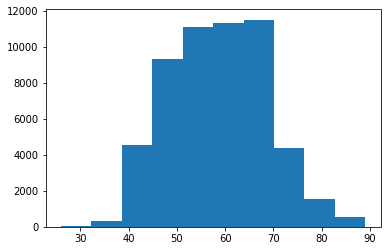

In [3]:
import matplotlib.pyplot as plt
plt.hist(train.age)

(array([   59.,   341.,  4562.,  9344., 11092., 11321., 11511.,  4380.,
         1530.,   529.]),
 array([26. , 32.3, 38.6, 44.9, 51.2, 57.5, 63.8, 70.1, 76.4, 82.7, 89. ]),
 <BarContainer object of 10 artists>)

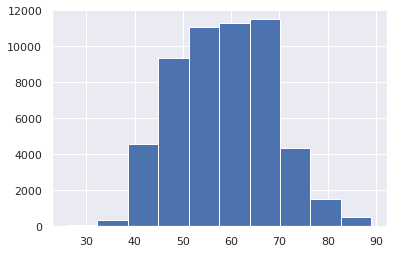

In [6]:
import seaborn as sns
sns.set()
plt.hist(train.age)